In [73]:
import pystac_client
import matplotlib.pyplot as plt
from pyproj import Transformer
from datetime import timedelta

In [74]:
catalog = pystac_client.Client.open(
    "https://stac.core.eopf.eodc.eu"
)

In [75]:
list(catalog.get_collections())

[<CollectionClient id=sentinel-2-l2a>,
 <CollectionClient id=sentinel-1-l1-grd>,
 <CollectionClient id=sentinel-3-slstr-l2-lst>,
 <CollectionClient id=sentinel-3-slstr-l1-rbt>,
 <CollectionClient id=sentinel-3-olci-l2-lfr>,
 <CollectionClient id=sentinel-3-olci-l1-err>,
 <CollectionClient id=sentinel-3-olci-l2-lrr>,
 <CollectionClient id=sentinel-3-olci-l1-efr>,
 <CollectionClient id=sentinel-2-l1c>,
 <CollectionClient id=sentinel-1-l2-ocn>,
 <CollectionClient id=sentinel-1-l1-slc>,
 <CollectionClient id=sentinel-3-slstr-l2-frp>]

In [76]:
bbox_villaviciosa = [
    -5.432,   # min lon
    43.497,  # min lat
    -5.374,   # max lon
    43.534   # max lat
]

temporal_extent = ["2022-01-01", None] 

In [77]:
items = list(
    catalog.search(
        collections=["sentinel-2-l2a"],
        bbox=bbox_villaviciosa,
        datetime=temporal_extent,
        #query={"eo:cloud_cover": {"lt": 50}},
    ).items()
)
print(f"Found {len(items)} Sentinel-2 L2A products")
for item in items:
    print(item.datetime)

#remove elements with duplicate dates (keep first)
unique_dates = {}
for item in items:
    date_str = item.datetime.date().isoformat()
    if date_str not in unique_dates:
        unique_dates[date_str] = item
items = list(unique_dates.values())
print(f"After removing duplicates, {len(items)} items remain.")

/home/pablo/Proyectos/sentineltarr/.venv/lib/python3.11/site-packages/pystac/item.py:483: DeprecatedWarning: The item 'S2B_MSIL2A_20251104T112139_N0511_R037_T30TUP_20251104T134759' is deprecated.
  warnings.warn(
/home/pablo/Proyectos/sentineltarr/.venv/lib/python3.11/site-packages/pystac/item.py:483: DeprecatedWarning: The item 'S2B_MSIL2A_20251104T112139_N0511_R037_T29TQJ_20251104T134759' is deprecated.
  warnings.warn(
/home/pablo/Proyectos/sentineltarr/.venv/lib/python3.11/site-packages/pystac/item.py:483: DeprecatedWarning: The item 'S2A_MSIL2A_20251101T112241_N0511_R037_T30TUP_20251101T151319' is deprecated.
  warnings.warn(
/home/pablo/Proyectos/sentineltarr/.venv/lib/python3.11/site-packages/pystac/item.py:483: DeprecatedWarning: The item 'S2A_MSIL2A_20251101T112241_N0511_R037_T29TQJ_20251101T151319' is deprecated.
  warnings.warn(
/home/pablo/Proyectos/sentineltarr/.venv/lib/python3.11/site-packages/pystac/item.py:483: DeprecatedWarning: The item 'S2B_MSIL2A_20251101T111119_N0

Found 292 Sentinel-2 L2A products
2026-01-28 11:23:21.025000+00:00
2026-01-28 11:23:21.025000+00:00
2026-01-25 11:13:41.025000+00:00
2026-01-25 11:13:41.025000+00:00
2026-01-23 11:22:49.024000+00:00
2026-01-23 11:22:49.024000+00:00
2026-01-18 11:24:11.025000+00:00
2026-01-18 11:24:11.025000+00:00
2026-01-15 11:14:21.025000+00:00
2026-01-15 11:14:21.025000+00:00
2026-01-13 11:23:29.024000+00:00
2026-01-13 11:23:29.024000+00:00
2026-01-10 11:21:31.024000+00:00
2026-01-10 11:21:31.024000+00:00
2026-01-10 11:13:39.024000+00:00
2026-01-10 11:13:39.024000+00:00
2026-01-08 11:24:51.025000+00:00
2026-01-03 11:23:59.024000+00:00
2025-12-31 11:13:59.024000+00:00
2025-12-31 11:13:59.024000+00:00
2025-12-29 11:25:11.025000+00:00
2025-12-28 11:15:21.024000+00:00
2025-12-26 11:15:01.025000+00:00
2025-12-21 11:25:21.024000+00:00
2025-12-21 11:13:59.024000+00:00
2025-12-19 11:25:11.025000+00:00
2025-12-18 11:15:11.024000+00:00
2025-12-18 11:15:11.024000+00:00
2025-12-16 11:15:01.025000+00:00
2025-12-1

## Tidal Prediction and Filtering Sentinel-2 Items

In [78]:
import numpy as np
from datetime import datetime, timezone

def get_tide_gijon(dt_target):
    """
    Calculates tide height relative to Mean Sea Level for Gijón/Villaviciosa.
    Pure Python/Numpy - No compiler or complex libraries required.
    """
    # 1. Reference Time (January 1, 2026, 00:00:00 UTC)
    t0 = datetime(2026, 1, 1, tzinfo=timezone.utc)
    # Hours passed since the start of the year
    hours = (dt_target - t0).total_seconds() / 3600.0

    # 2. Gijón Harmonic Constituents (Name: [Speed deg/hour, Amplitude m, Phase deg])
    # Data source: Simplified from Puertos del Estado official records
    constituents = {
        'M2': [28.984104, 1.13, 71.4],   # Main Lunar
        'S2': [30.000000, 0.38, 102.1],  # Main Solar
        'N2': [28.439730, 0.22, 52.8],   # Elliptic Lunar
        'K1': [15.041069, 0.07, 65.2],   # Luni-Solar Declinational
        'O1': [13.943035, 0.06, 315.4],  # Main Lunar Declinational
    }

    height = 0
    for name, (speed, amp, phase) in constituents.items():
        # Tidal formula: Height = Amp * cos(speed * time - phase)
        # Convert degrees to radians for np.cos
        radian_factor = np.pi / 180.0
        height += amp * np.cos((speed * hours - phase) * radian_factor)
    
    return height

def is_near_low_tide(dt_target, window_minutes=60):
    """
    Checks if a given datetime is within X minutes of a Low Tide in Gijón/Villaviciosa.
    """
    # 1. Create a range of times: 3 hours before to 3 hours after (full tide cycle)
    # We check every minute in this 6-hour block
    check_range = [dt_target + timedelta(minutes=i) for i in range(-180, 180)]
    
    # 2. Calculate heights for the whole range
    heights = [get_tide_gijon(t) for t in check_range]
    
    # 3. Find the index of the minimum height (Low Tide)
    min_idx = np.argmin(heights)
    low_tide_time = check_range[min_idx]
    
    # 4. Calculate the difference between our target and the actual Low Tide
    time_diff = abs((dt_target - low_tide_time).total_seconds() / 60.0)
    
    is_near = time_diff <= window_minutes
    return is_near

In [79]:
def calculate_cloud_cover_in_bbox(datacube_sample, bbox):
    """
    Calculates the percentage of cloud cover within the specified bounding box
    using the SCL band.
    """
    crs = datacube_sample.rio.crs
    transformer = Transformer.from_crs("EPSG:4326", crs, always_xy=True)
    minx, miny = transformer.transform(bbox[0], bbox[1])
    maxx, maxy = transformer.transform(bbox[2], bbox[3])

    # Select the SCL band and clip to the bounding box
    scl = datacube_sample["scl"].sel(x=slice(minx, maxx), y=slice(maxy, miny))

    # Define cloud SCL values (you might need to adjust these based on your needs)
    cloud_scl_values = [9] 

    # Create a boolean mask for cloud pixels
    cloud_mask = scl.isin(cloud_scl_values)

    # Calculate the percentage of cloud pixels
    total_pixels = cloud_mask.size
    if total_pixels == 0:
        return 0.0 # Avoid division by zero if bbox is outside image
    
    # Corrected line: call .compute() to trigger Dask array computation
    cloud_pixels = cloud_mask.sum().compute().item() 
    cloud_percentage = (cloud_pixels / total_pixels) * 100
    
    return cloud_percentage

In [80]:
item = items[0]
list(item.assets.keys())

['SR_10m',
 'SR_20m',
 'SR_60m',
 'AOT_10m',
 'B01_20m',
 'B02_10m',
 'B03_10m',
 'B04_10m',
 'B05_20m',
 'B06_20m',
 'B07_20m',
 'B08_10m',
 'B09_60m',
 'B11_20m',
 'B12_20m',
 'B8A_20m',
 'SCL_20m',
 'TCI_10m',
 'WVP_10m',
 'product',
 'zipped_product',
 'product_metadata']

Item 0 - 2026-01-28 11:23:21.025000+00:00 is not near low tide.
Item 1 - 2026-01-25 11:13:41.025000+00:00 is not near low tide.
Item 2 - 2026-01-23 11:22:49.024000+00:00 is not near low tide.
Item 3 - 2026-01-18 11:24:11.025000+00:00 is not near low tide.
Item 4 - 2026-01-15 11:14:21.025000+00:00 is not near low tide.
Item 5 - 2026-01-13 11:23:29.024000+00:00 is not near low tide.
Item 6 - 2026-01-10 11:21:31.024000+00:00 is not near low tide.
Item 7 - 2026-01-08 11:24:51.025000+00:00 is not near low tide.
Item 8 - 2026-01-03 11:23:59.024000+00:00 is not near low tide.
Item 9 - 2025-12-31 11:13:59.024000+00:00 is not near low tide.
Item 10 - 2025-12-29 11:25:11.025000+00:00 is not near low tide.
Item 11 - 2025-12-28 11:15:21.024000+00:00 is not near low tide.
Item 12 - 2025-12-26 11:15:01.025000+00:00 is not near low tide.
Cloud cover 0.0


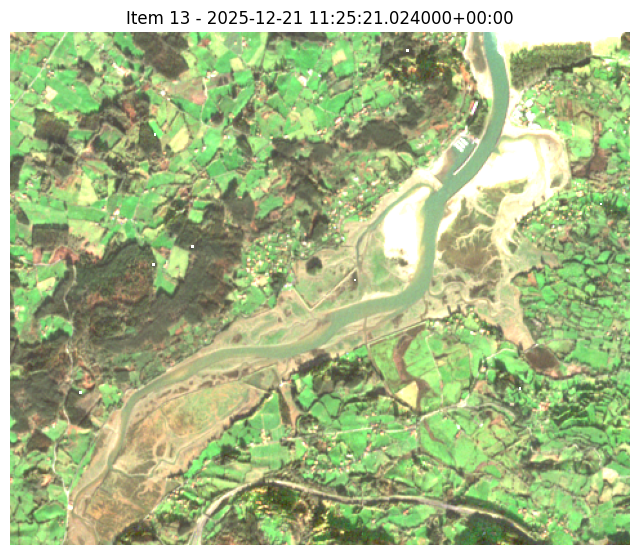

Item 14 - 2025-12-19 11:25:11.025000+00:00 is not near low tide.
Item 15 - 2025-12-18 11:15:11.024000+00:00 is not near low tide.
Item 16 - 2025-12-16 11:15:01.025000+00:00 is not near low tide.
Item 17 - 2025-12-14 11:23:59.024000+00:00 is not near low tide.
Item 18 - 2025-12-11 11:25:11.024000+00:00 is not near low tide.
Item 19 - 2025-12-09 11:25:01.026000+00:00 is not near low tide.
Item 20 - 2025-12-08 11:15:01.024000+00:00 is not near low tide.
Cloud cover 25.519489338584815
Item 21 - 2025-12-06 11:14:51.025000+00:00 skipped due to high cloud cover.
Item 22 - 2025-12-04 11:23:39.024000+00:00 is not near low tide.
Item 23 - 2025-12-01 11:24:51.024000+00:00 is not near low tide.
Item 24 - 2025-11-29 11:24:31.025000+00:00 is not near low tide.
Item 25 - 2025-11-28 11:14:31.024000+00:00 is not near low tide.
Item 26 - 2025-11-26 11:14:21.025000+00:00 is not near low tide.
Item 27 - 2025-11-24 11:23:09.024000+00:00 is not near low tide.
Could not open dataset for item 28 - 2025-11-21 

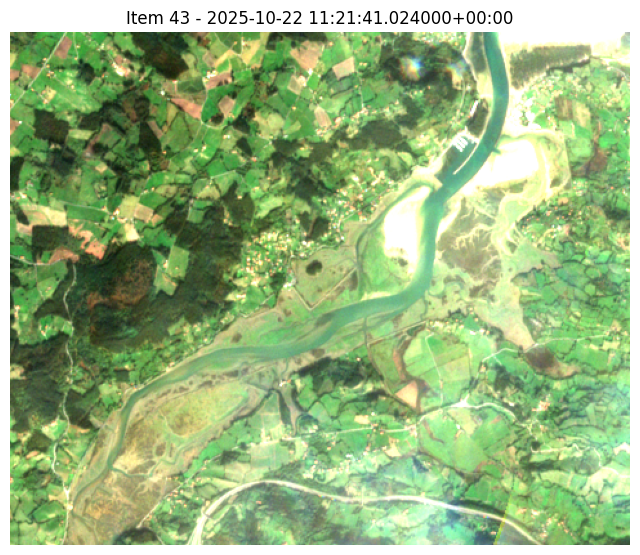

Item 44 - 2025-10-20 11:21:31.025000+00:00 is not near low tide.
Item 45 - 2025-10-19 11:11:11.024000+00:00 is not near low tide.
Item 46 - 2025-10-17 11:11:01.025000+00:00 is not near low tide.
Item 47 - 2025-10-15 11:21:09.024000+00:00 is not near low tide.
Item 48 - 2025-10-12 11:21:31.024000+00:00 is not near low tide.
Item 49 - 2025-10-10 11:21:31.025000+00:00 is not near low tide.
Could not open dataset for item 50 - 2025-10-09 11:10:01.024000+00:00
Could not open dataset for item 51 - 2025-10-07 11:09:51.025000+00:00
Item 52 - 2025-10-05 11:21:09.024000+00:00 is not near low tide.
Item 53 - 2025-10-02 11:21:31.024000+00:00 is not near low tide.
Item 54 - 2025-09-30 11:21:31.025000+00:00 is not near low tide.
Item 55 - 2025-09-29 11:08:51.024000+00:00 is not near low tide.
Item 56 - 2025-09-27 11:08:41.025000+00:00 is not near low tide.
Item 57 - 2025-09-25 11:21:09.024000+00:00 is not near low tide.
Cloud cover 86.342314483018
Item 58 - 2025-09-22 11:21:31.024000+00:00 skipped d

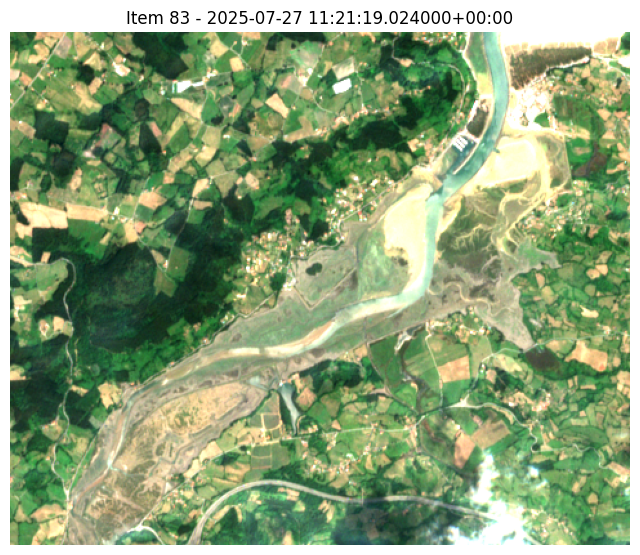

Could not open dataset for item 84 - 2025-07-12 11:21:41.025000+00:00
Could not open dataset for item 85 - 2025-07-11 11:06:51.024000+00:00
Item 86 - 2025-07-07 11:21:19.024000+00:00 is not near low tide.
Item 87 - 2025-07-04 11:21:31.024000+00:00 is not near low tide.
Item 88 - 2025-07-02 11:21:41.025000+00:00 is not near low tide.
Item 89 - 2025-07-01 11:07:11.024000+00:00 is not near low tide.
Item 90 - 2025-06-29 11:06:41.025000+00:00 is not near low tide.
Could not open dataset for item 91 - 2025-06-27 11:21:19.024000+00:00
Item 92 - 2025-06-24 11:21:31.024000+00:00 is not near low tide.
Item 93 - 2025-06-22 11:21:31.025000+00:00 is not near low tide.
Item 94 - 2025-06-21 11:06:51.024000+00:00 is not near low tide.
Item 95 - 2025-06-19 11:06:41.025000+00:00 is not near low tide.
Item 96 - 2025-06-17 11:21:09.025000+00:00 is not near low tide.
Could not open dataset for item 97 - 2025-06-14 11:21:31.024000+00:00
Could not open dataset for item 98 - 2025-06-12 11:21:31.025000+00:00


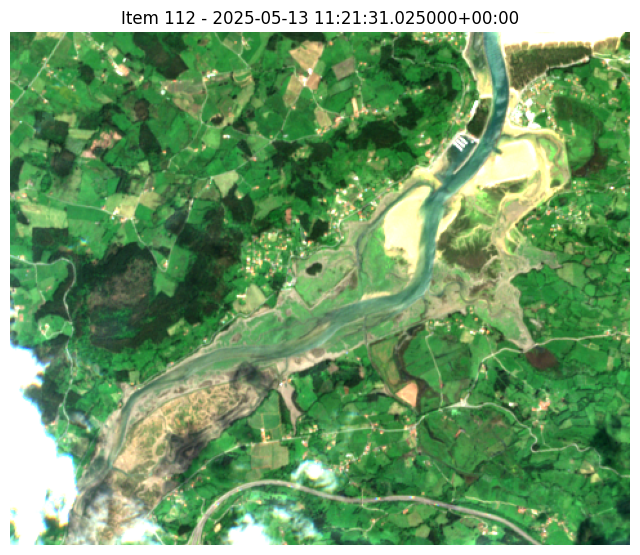

Cloud cover 0.0


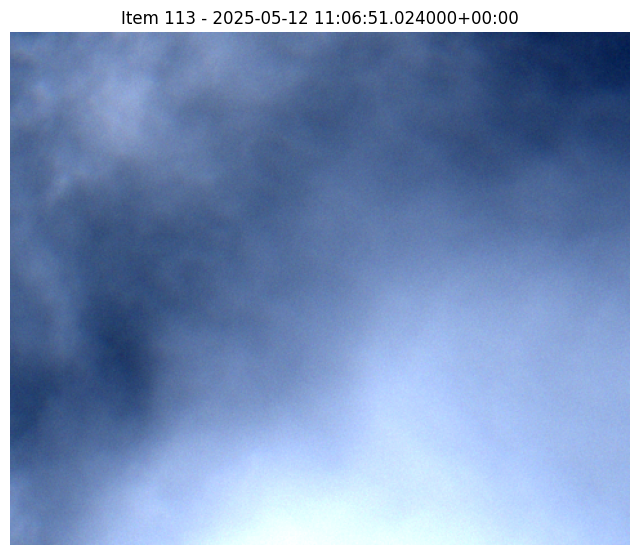

Item 114 - 2025-05-10 11:06:41.025000+00:00 is not near low tide.
Item 115 - 2025-05-08 11:21:19.024000+00:00 is not near low tide.
Item 116 - 2025-05-05 11:21:31.024000+00:00 is not near low tide.
Item 117 - 2025-05-03 11:21:31.025000+00:00 is not near low tide.
Item 118 - 2025-05-02 11:07:01.024000+00:00 is not near low tide.
Item 119 - 2025-04-30 11:06:41.025000+00:00 is not near low tide.
Cloud cover 0.0


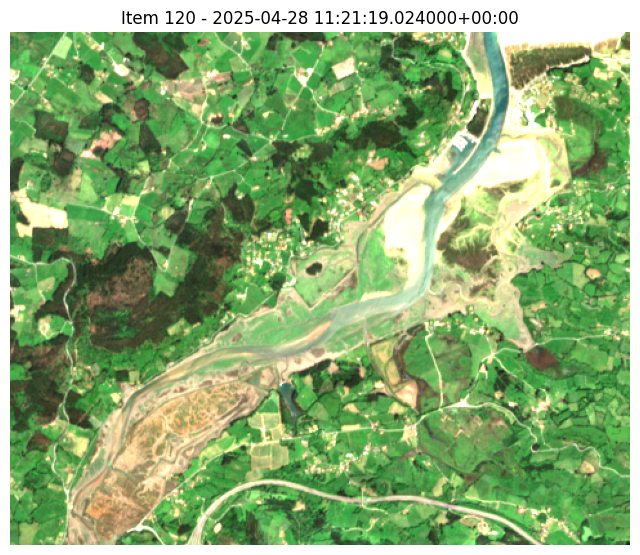

Item 121 - 2025-04-25 11:21:31.024000+00:00 is not near low tide.
Item 122 - 2025-04-23 11:21:41.025000+00:00 is not near low tide.
Item 123 - 2025-04-22 11:06:51.024000+00:00 is not near low tide.
Item 124 - 2025-04-20 11:06:41.025000+00:00 is not near low tide.
Item 125 - 2025-04-18 11:21:19.024000+00:00 is not near low tide.
Cloud cover 40.19316959015452
Item 126 - 2025-04-15 11:21:31.024000+00:00 skipped due to high cloud cover.
Cloud cover 100.0
Item 127 - 2025-04-13 11:21:31.025000+00:00 skipped due to high cloud cover.
Item 128 - 2025-04-10 11:06:41.025000+00:00 is not near low tide.
Item 129 - 2025-04-08 11:21:19.024000+00:00 is not near low tide.
Item 130 - 2025-04-05 11:21:31.024000+00:00 is not near low tide.
Item 131 - 2024-12-04 11:24:41.024000+00:00 is not near low tide.
Cloud cover 77.629958117763
Item 132 - 2024-12-01 11:14:31.024000+00:00 skipped due to high cloud cover.


In [83]:
import xarray as xr

def plot_rgb_image(datacube_sample, bbox, title):
    crs = datacube_sample.rio.crs
    transformer = Transformer.from_crs("EPSG:4326", crs, always_xy=True)
    minx, miny = transformer.transform(bbox[0], bbox[1])
    maxx, maxy = transformer.transform(bbox[2], bbox[3])

    datacube_sample = datacube_sample.sel(x=slice(minx, maxx), y=slice(maxy, miny))

    rgb = datacube_sample[["b04", "b03", "b02"]].to_dataarray(dim="band")
    rgb = rgb.assign_coords(band=["red", "green", "blue"])

    vmin = float(rgb.min())
    vmax = float(rgb.quantile(0.95))
    rgb_scaled = (rgb - vmin) / (vmax - vmin)
    rgb_scaled = rgb_scaled.clip(0, 1)

    rgb_img = rgb_scaled.transpose("y", "x", "band").values

    x = datacube_sample.x.values
    y = datacube_sample.y.values

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(rgb_img, extent=[x.min(), x.max(), y.min(), y.max()])

    ax.set_title(title)
    ax.axis("off")
    plt.show()


for i, item in enumerate(items):
    try:
        if is_near_low_tide(item.datetime, window_minutes=60):
            ds = xr.open_dataset(item.assets["product"].href, engine="eopf-zarr")
            cloud_cover = calculate_cloud_cover_in_bbox(ds, bbox_villaviciosa)
            print("Cloud cover", cloud_cover)
            if cloud_cover < 10:
                plot_rgb_image(ds, bbox_villaviciosa, f"Item {i} - {item.datetime}")
            else:
                print(f"Item {i} - {item.datetime} skipped due to high cloud cover.")
        else:
            print(f"Item {i} - {item.datetime} is not near low tide.")
    except FileNotFoundError:
        print(f"Could not open dataset for item {i} - {item.datetime}")


In [ ]:
def plot_water_mask(datacube_sample):
    # Plot the water mask separately
    fig, ax = plt.subplots(figsize=(8, 8))
    # Mask water using SCL (class 6 = water), interpolated to 10m
    scl = datacube_sample["scl"]
    water_mask = scl == 6
    ax.imshow(water_mask, extent=[scl.x.min(), scl.x.max(), scl.y.min(), scl.y.max()], cmap='Blues')
    ax.set_title("Water Mask (SCL class 6)")
    ax.axis("off")
    plt.show()